In [1]:
#Import relevant libraries
from keras.models import Sequential
import pandas as pd
from keras.layers import Dense
import matplotlib as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from keras.optimizers import SGD
import os
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

Using TensorFlow backend.


In [2]:
#Set working directory
os.chdir("/Users/millie9_9/Desktop/Data Science")

#Load data
data = pd.read_csv('diabetes.csv', delimiter=',')

print(data)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
5              5      116             74              0        0  25.6   
6              3       78             50             32       88  31.0   
7             10      115              0              0        0  35.3   
8              2      197             70             45      543  30.5   
9              8      125             96              0        0   0.0   
10             4      110             92              0        0  37.6   
11            10      168             74              0        0  38.0   
12            10      139             

In [4]:
#Basic information
print(data.info())
#Check for NAs
data.isna().sum()
#No NAs. However, there exist 0 values that are non-informative (see code below)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [ ]:
pd.value_counts(data['Glucose'].values, sort=False)

In [ ]:
pd.value_counts(data['BloodPressure'].values, sort=False)

In [ ]:
pd.value_counts(data['SkinThickness'].values, sort=False)

In [ ]:
pd.value_counts(data['Insulin'].values, sort=False)

In [ ]:
pd.value_counts(data['BMI'].values, sort=False)

In [5]:
#We replace 0's that do not conceptually make sense and are thus NA's with averages
#We first replace 0's with NAs so they do not count in our average
data['Glucose']=data['Glucose'].replace(0,np.nan)
data['BloodPressure']=data['BloodPressure'].replace(0,np.nan)
data['SkinThickness']=data['SkinThickness'].replace(0,np.nan)
data['Insulin']=data['Insulin'].replace(0,np.nan)
data['BMI']=data['BMI'].replace(0,np.nan)

#We then replace NA's with average
data['Glucose']=data['Glucose'].replace(np.nan,data['Glucose'].mean())
data['BloodPressure']=data['BloodPressure'].replace(np.nan,data['BloodPressure'].mean())
data['SkinThickness']=data['SkinThickness'].replace(np.nan,data['SkinThickness'].mean())
data['Insulin']=data['Insulin'].replace(np.nan,data['Insulin'].mean())
data['BMI']=data['BMI'].replace(np.nan,data['BMI'].mean())

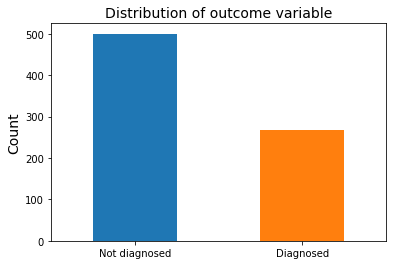

In [6]:
#Plot outcome as to balance of data
data['Outcome'].value_counts().plot(kind='bar')
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of outcome variable',fontsize=14)
plt.xticks([0,1],['Not diagnosed','Diagnosed'])
plt.xticks(rotation=0)
plt.savefig('outcome_distribution.png')

In [7]:
#Count of outcome (diabetes no diabetes)
data['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

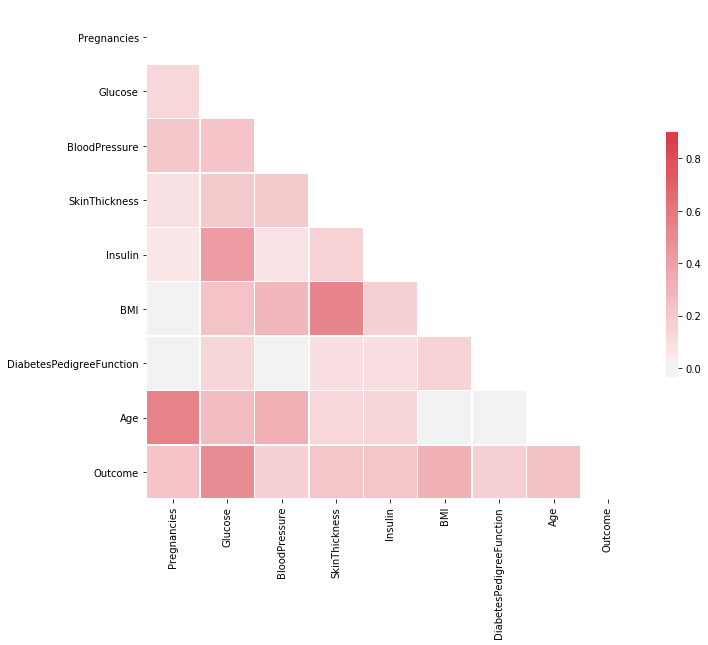

In [8]:
#Correlation matrix
#Compute the correlation matrix with the default Pearson correlation coefficients
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, vmax=.9,cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#Note: diverging_palette (setting colours only works with versions of numpy >= 1.18.0)

In [9]:
#Defne data and convert to NumPy arrays  
dataInNumpy = data.values 
X = dataInNumpy[:,:8]
y = dataInNumpy[:,8:]

#Normalize input features
#Define scaler
scaler = MinMaxScaler(feature_range=(0,1))
#Fit and transform
X = scaler.fit_transform(X)

#Labels for feature
list_features = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','PedigreeFunction','Age']

In [10]:
#Split data in (70/30) train and validation (and stratify based on outcome-variable)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.30)

In [11]:
#Build Neural-Network classifier
def base_model():
    #Define layer structure
    model = Sequential()        
    model.add(Dense(8, input_dim=8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    #Compile model - set model parameters
    model.compile(loss='binary_crossentropy', optimizer=SGD(lr=0.1), metrics=['accuracy'])
    return model

In [12]:
#Specify model in KerasClassifier (Keras wrapper that is compatible with SciKit-learn and Eli5)
my_model = KerasClassifier(build_fn=base_model)

#Fit the model on training data
history = my_model.fit(X_train,y_train, epochs=300, batch_size=20, verbose=0)


In [16]:
#Inspect accuracy and loss of training
history.history

{'loss': [0.6736512068707627,
  0.6525147048898693,
  0.6456787236575974,
  0.6419662615662403,
  0.6372753547112591,
  0.6314172342946853,
  0.6253173402345824,
  0.6158288044636476,
  0.6057503137952567,
  0.5927790635346922,
  0.5790850784303534,
  0.5629125812422185,
  0.5518226046357962,
  0.5357691240488262,
  0.5272485960129253,
  0.5161054481785169,
  0.505991908258566,
  0.5013342014682137,
  0.49426407398902283,
  0.4883941830425511,
  0.4903105296458168,
  0.4853208005650305,
  0.49033262154687496,
  0.479270372088839,
  0.480434916871886,
  0.481218171852261,
  0.4828527076395308,
  0.4745154324190577,
  0.4811299423820702,
  0.48127127614989185,
  0.47180615240635154,
  0.47433267852891536,
  0.4762136131469542,
  0.4727840935828743,
  0.4715888186096035,
  0.47918527630232344,
  0.4686062251611351,
  0.47372167070484694,
  0.47605332637854353,
  0.47235609532734535,
  0.469731303566661,
  0.4735180650121451,
  0.4713024286695477,
  0.4701313944724241,
  0.4681169912357792

In [13]:
#Permutation Importance - calculate global permutation feature importance values on validation data
perm = PermutationImportance(my_model, cv='prefit').fit(X_test,y_test)
eli5.show_weights(perm,feature_names=list_features)

231/231 [==============================] - 0s 58us/step


Weight,Feature
0.1013 ± 0.0467,Glucose
0.0433 ± 0.0274,BMI
0.0216 ± 0.0245,PedigreeFunction
0.0139 ± 0.0302,Age
0.0104 ± 0.0088,Insulin
0.0052 ± 0.0159,BloodPressure
0.0043 ± 0.0122,SkinThickness
0.0017 ± 0.0277,Pregnancies


In [23]:
#See scores for each iteration (before average is calculated)
perm.results_

[array([0.00432897, 0.06493503, 0.00432897, 0.        , 0.00865799,
        0.04329002, 0.01731598, 0.03463203]),
 array([ 0.01731598,  0.12121212,  0.01298702, -0.00432903,  0.00432897,
         0.01731598,  0.03463203,  0.00865799]),
 array([-0.02164507,  0.1168831 ,  0.00432897,  0.01298702,  0.00865799,
         0.04761904,  0.02597398, -0.00865805]),
 array([-0.00432903,  0.08225107,  0.01298702,  0.00432897,  0.01298702,
         0.05627704,  0.        ,  0.00865799]),
 array([ 0.01298702,  0.12121212, -0.00865805,  0.00865799,  0.01731598,
         0.05194801,  0.030303  ,  0.02597398])]

In [24]:
#See accuracy without any permutatuons (base scores)
perm.scores_

array([0.76623374, 0.76623374, 0.76623374, 0.76623374, 0.76623374])

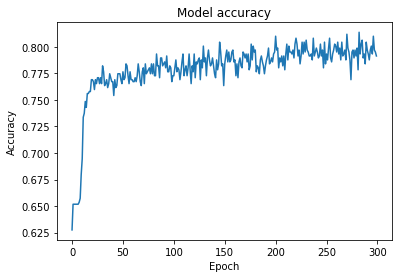

In [14]:
#See training loss + accuracy for model
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.savefig('Model_accuracy')

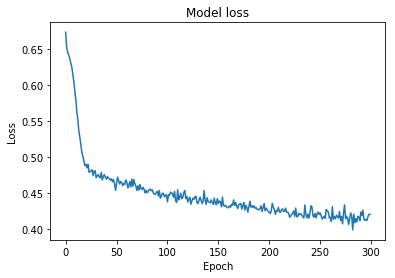

In [15]:
#Check loss to secure that training works
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.savefig('Model_loss')